In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

case_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/CTEPH_pqtl_result.pkl"
control_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/NAGA_pqtl_result.pkl"
reported_loci_info_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/datasrc/cteph_reported_loci.xlsx"

case_pqtl = pd.read_pickle(case_pqtl_path)
control_pqtl = pd.read_pickle(control_pqtl_path)
reported_loci_info = pd.read_excel(reported_loci_info_path)

In [7]:
reported_loci_info

,CHROM,POS,ID,REF,ALT,GENE,RS,COUNTRY
0,chr4,154586438,chr4:154586438:T:C,T,C,FGA,rs6050,"UK, CN"
1,chr4,154590745,chr4:154590745:T:C,T,C,FGA,rs2070011,JP
2,chr4,154568456,chr4:154568456:C:T,C,T,FGB,rs6054,US
3,chr4,154599778,chr4:154599778:G:A,G,A,FGG,rs7659024,UK
4,chr9,127824409,chr9:127824409:G:A,G,A,ENG,rs3739817,CN
5,chr9,5073770,chr9:5073770:G:T,G,T,JAK2,rs77375493,DE
6,chr1,169514323,chr1:169514323:T:C,T,C,F5,rs6027,JP
7,chr4,186286227,chr4:186286227:C:T,C,T,F11,rs2289252,UK
8,chr20,23048087,chr20:23048087:G:A,G,A,THBD,rs1042579,JP
9,chr9,133261703,chr9:133261703:A:G,A,G,ABO,rs687289,UK


In [2]:
model = "additive"

In [3]:
import pandas as pd

results_dict = {}

for key in case_pqtl.keys():

    case_ids = case_pqtl[key][case_pqtl[key][f'{model}_pvalue'] < 0.05]['SeqId']
    control_ids = control_pqtl[key][control_pqtl[key][f'{model}_pvalue'] < 0.05]['SeqId']
    # unique_ids = pd.concat([case_ids, control_ids]).drop_duplicates().tolist()
    unique_ids = case_ids[case_ids.isin(control_ids)].tolist()

    results = []
    for seq_id in unique_ids:
        if seq_id in case_pqtl[key]['SeqId'].values:
            case_row = case_pqtl[key][case_pqtl[key]['SeqId'] == seq_id]
            case_beta = case_row[f'{model}_beta'].iloc[0]
            case_pvalue = case_row[f'{model}_pvalue'].iloc[0]
        else:
            case_beta = None
            case_pvalue = None

        if seq_id in control_pqtl[key]['SeqId'].values:
            control_row = control_pqtl[key][control_pqtl[key]['SeqId'] == seq_id]
            control_beta = control_row[f'{model}_beta'].iloc[0]
            control_pvalue = control_row[f'{model}_pvalue'].iloc[0]
        else:
            control_beta = None
            control_pvalue = None

        results.append({
            'SeqId': seq_id,
            'case_beta': case_beta,
            'case_pvalue': case_pvalue,
            'control_beta': control_beta,
            'control_pvalue': control_pvalue
        })

    results_dict[key] = pd.DataFrame(results)


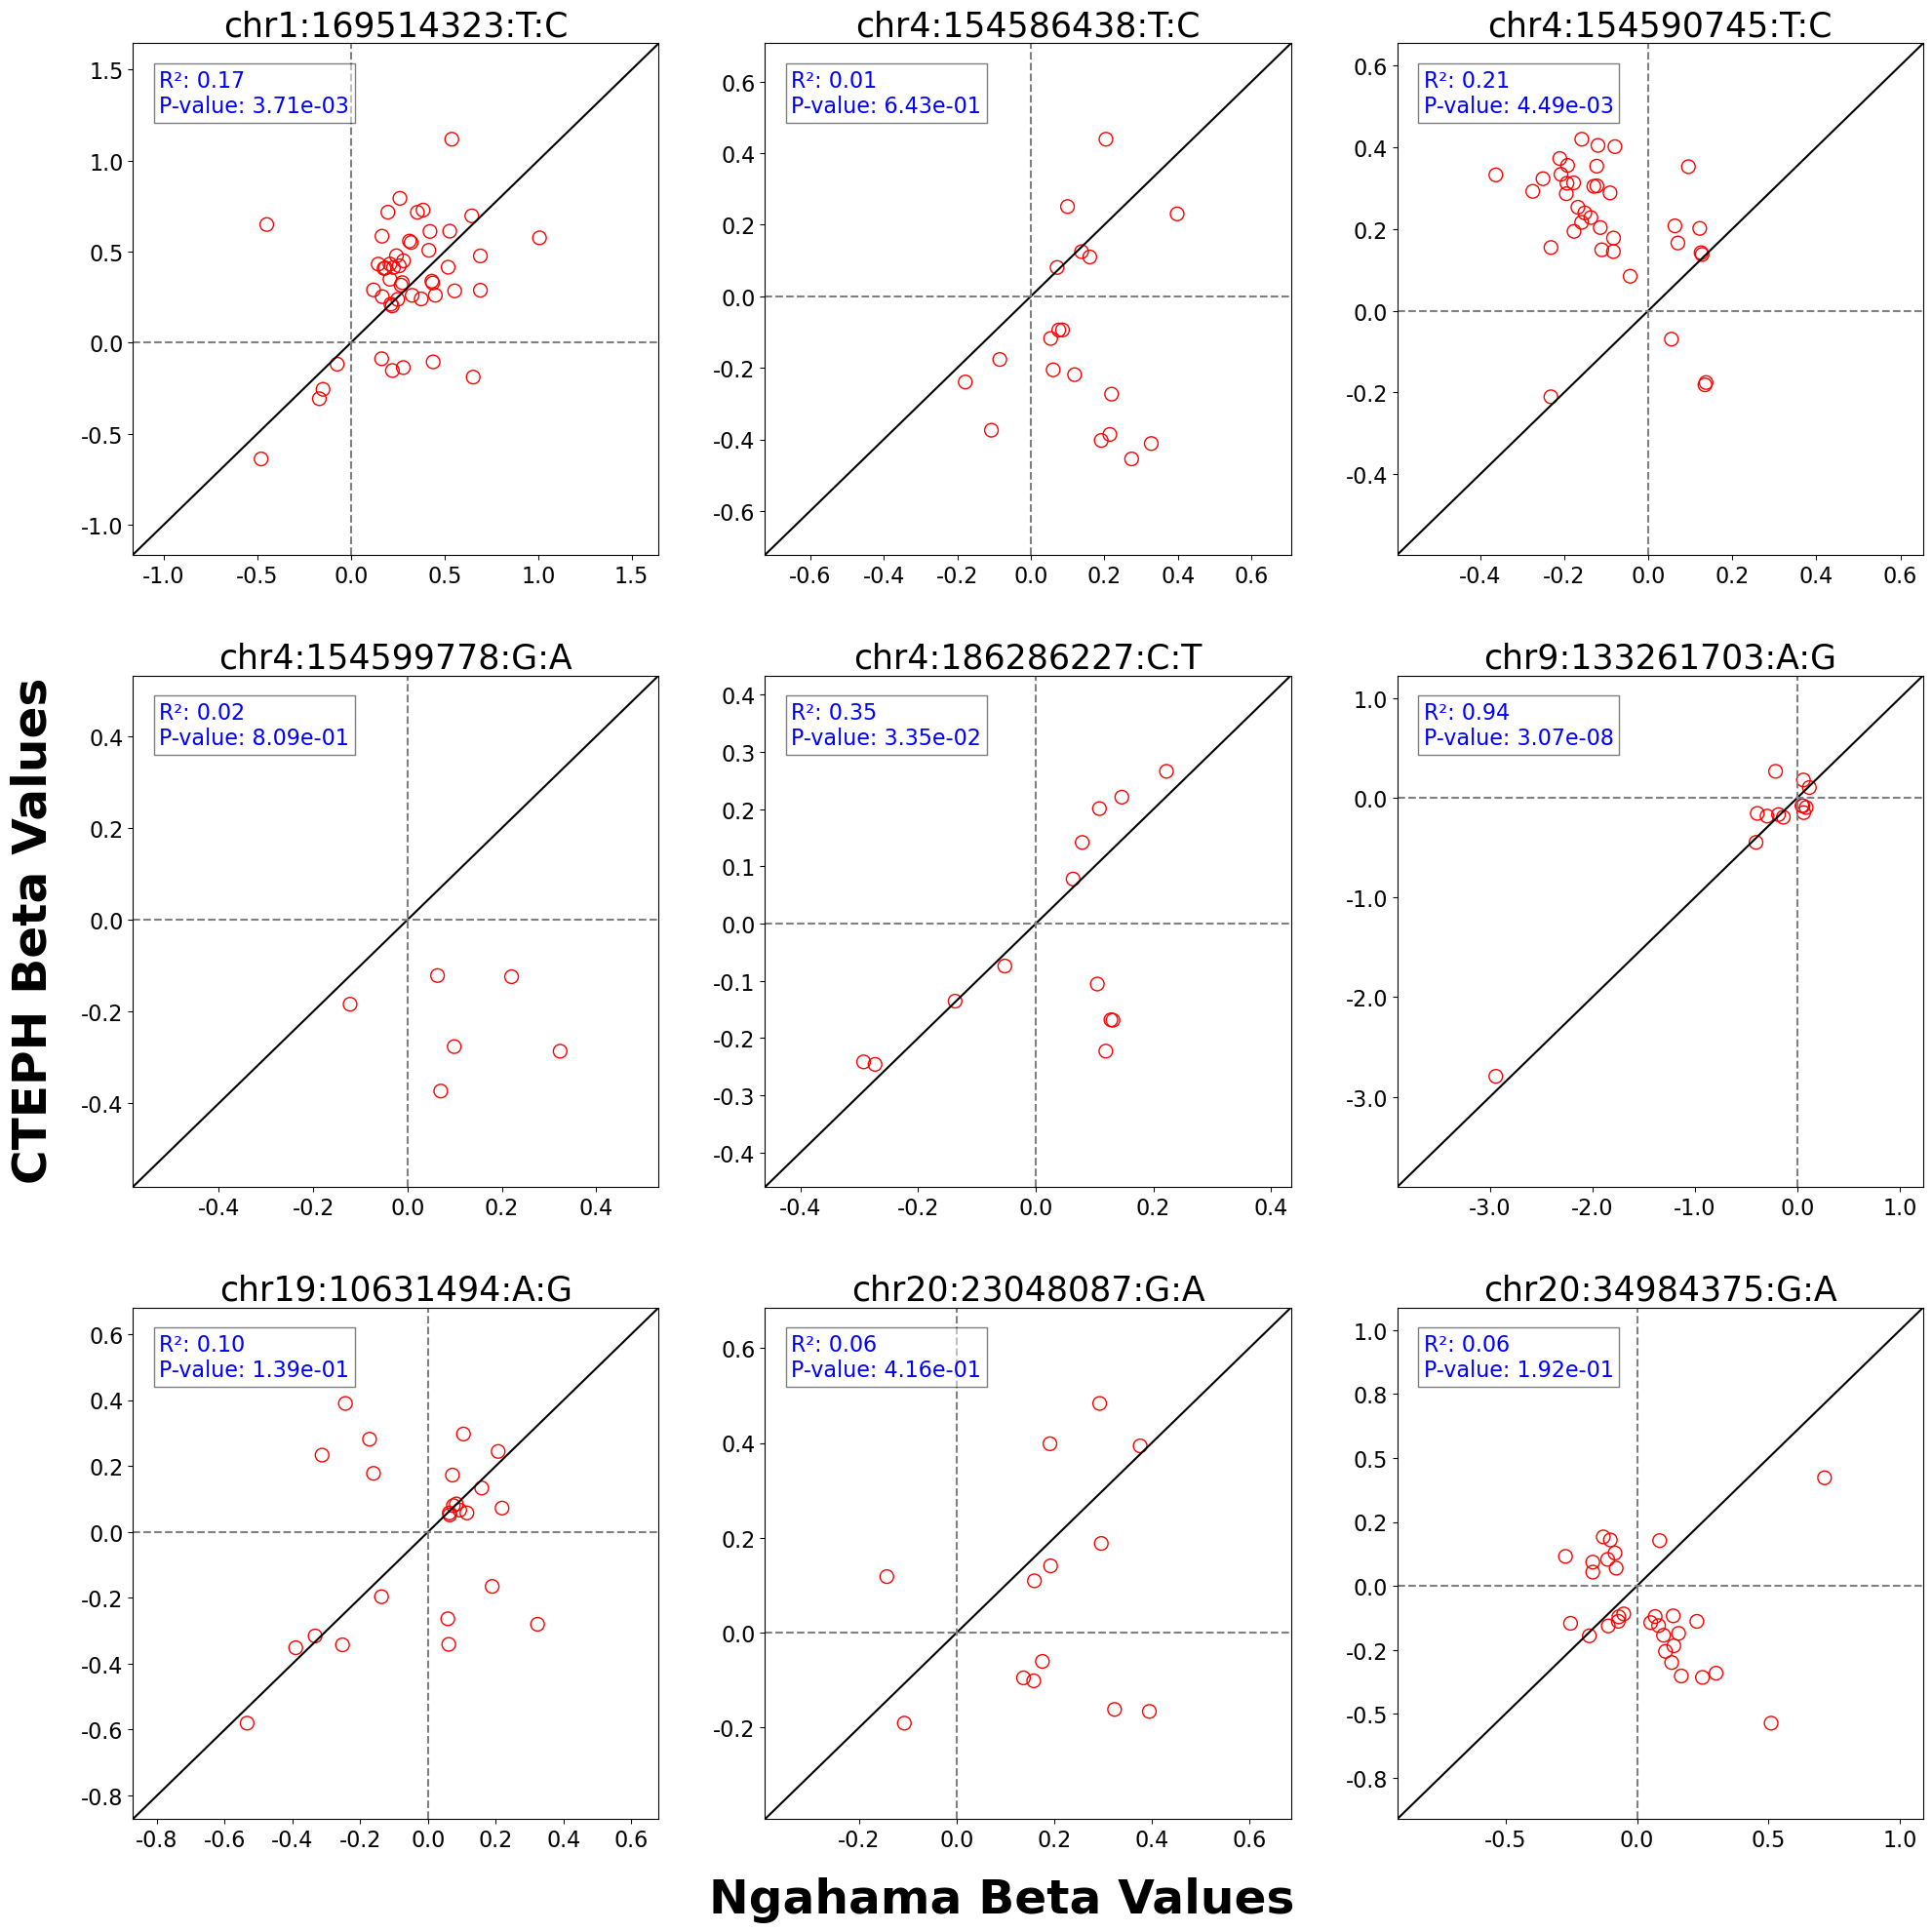

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from scipy.stats import linregress

keys = list(case_pqtl.keys())
fig, axes = plt.subplots(3, 3, figsize=(20, 20)) 
axes = axes.flatten() # flatten the 2D array of axes to 1D

# define a function to format the tick labels
def format_func(value, tick_number):
    return f'{value:.1f}'

# iterate over the results_dict and plot the data
for index, (key, df) in enumerate(results_dict.items()):
    
    ax = axes[index]
    control_betas = []
    case_betas = []
    
    for _, row in df.iterrows():
        color = 'red' if row['case_pvalue'] < 0.05 and row['control_pvalue'] < 0.05 else 'gray'
        ax.scatter(row['control_beta'], row['case_beta'], edgecolor=color, facecolors='none', marker='o', s=100)
        control_betas.append(row['control_beta'])
        case_betas.append(row['case_beta'])
    
    # calculate the linear regression
    control_betas = np.array(control_betas)
    case_betas = np.array(case_betas)
    slope, intercept, r_value, p_value, std_err = linregress(control_betas, case_betas)
    r_squared = r_value**2

    # calculate the buffer for the plot
    buffer = 0.3  # 30% buffer around the data
    min_beta = min(df['control_beta'].min(), df['case_beta'].min())
    max_beta = max(df['control_beta'].max(), df['case_beta'].max())
    range_extension = (max_beta - min_beta) * buffer
    min_beta_extended = min_beta - range_extension
    max_beta_extended = max_beta + range_extension
    
    # set the limits of the plot, with the buffer
    ax.set_xlim(min_beta_extended, max_beta_extended)
    ax.set_ylim(min_beta_extended, max_beta_extended)

    # y=x line
    ax.plot([min_beta_extended, max_beta_extended], [min_beta_extended, max_beta_extended], 'k-')

    # add a horizontal and vertical line at 0
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')

    # add a title to the subplot
    ax.set_title(f'{key}', fontsize=25)  # 调整标题大小
    ax.tick_params(axis='both', labelsize=16)  # 调整坐标轴刻度标签大小

    # add the linear regression equation to the plot
    ax.text(0.05, 0.95, f'R²: {r_squared:.2f}\nP-value: {p_value:.2e}', transform=ax.transAxes, verticalalignment='top', fontsize=16, color='blue', bbox=dict(facecolor='white', alpha=0.5))

    # format the tick labels
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))

# add global X and Y labels more appropriately and adjust their position
fig.text(0.5, 0.003, 'Ngahama Beta Values', ha='center', va='center', fontsize=35, weight='bold')  # Increase font size
fig.text(0.003, 0.5, 'CTEPH Beta Values', ha='center', va='center', rotation='vertical', fontsize=35, weight='bold')  # Increase font size

plt.style.use('default')
plt.tight_layout(pad=4.0)  # Increase padding between subplots
plt.show()